## 1 Import Libraries and Data

In [3]:
import os
from tkinter.constants import FIRST

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from pytz.exceptions import NonExistentTimeError
from tornado.autoreload import watch
# import Dataframes with cleaned data independently of the operating system (mac or windows or linux) in a pandas dataframe
charging_data = pd.read_pickle(os.path.join('..', 'Data', 'charging_data.pkl'))
weather_data = pd.read_pickle(os.path.join('..', 'Data', 'weather_data.pkl'))
agg_data_import = pd.read_pickle(os.path.join('..', 'Data', 'aggregated_data.pkl'))
agg_data_import['year'] = agg_data_import.index.year

In [4]:
# charging_data.head()
print(charging_data.columns)
# weather_data.head()
charging_data.head()


Index(['counter', 'id', 'connectionTime', 'disconnectTime', 'doneChargingTime',
       'kWhDelivered', 'sessionID', 'siteID', 'spaceID', 'stationID',
       'timezone', 'userID', 'connection_date', 'year_month',
       'charging_duration', 'connection_duration'],
      dtype='object')


,counter,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,connection_date,year_month,charging_duration,connection_duration
30793,0,5bc90cb9f9af8b0d7fe77cd2,2018-04-25 04:08:04-07:00,2018-04-25 06:20:10-07:00,2018-04-25 06:20:10-07:00,7.932,2_39_78_362_2018-04-25 11:08:04.400812,2,CA-496,2-39-78-362,America/Los_Angeles,,2018-04-25,2018-04,133.100000,132.100000
30794,1,5bc90cb9f9af8b0d7fe77cd3,2018-04-25 06:45:10-07:00,2018-04-25 17:56:16-07:00,2018-04-25 09:44:15-07:00,10.013,2_39_95_27_2018-04-25 13:45:09.617470,2,CA-319,2-39-95-27,America/Los_Angeles,,2018-04-25,2018-04,179.083333,671.100000
30795,2,5bc90cb9f9af8b0d7fe77cd4,2018-04-25 06:45:50-07:00,2018-04-25 16:04:45-07:00,2018-04-25 07:51:44-07:00,5.257,2_39_79_380_2018-04-25 13:45:49.962001,2,CA-489,2-39-79-380,America/Los_Angeles,,2018-04-25,2018-04,65.900000,558.916667
30796,3,5bc90cb9f9af8b0d7fe77cd5,2018-04-25 07:37:06-07:00,2018-04-25 16:55:34-07:00,2018-04-25 09:05:22-07:00,5.177,2_39_79_379_2018-04-25 14:37:06.460772,2,CA-327,2-39-79-379,America/Los_Angeles,,2018-04-25,2018-04,88.266667,558.466667
30797,4,5bc90cb9f9af8b0d7fe77cd6,2018-04-25 07:40:34-07:00,2018-04-25 16:03:12-07:00,2018-04-25 10:40:30-07:00,10.119,2_39_79_381_2018-04-25 14:40:33.638896,2,CA-490,2-39-79-381,America/Los_Angeles,,2018-04-25,2018-04,179.933333,502.633333


## 2 Descriptive Analysis

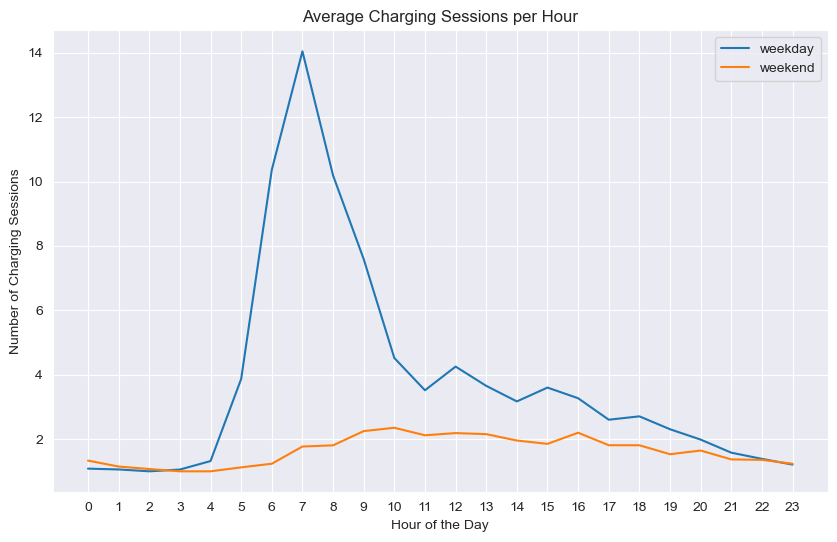

In [5]:
charging_data["day"] = charging_data["connectionTime"].dt.day_name()
charging_data['isWeekend'] = charging_data['day'].isin(['Saturday', 'Sunday'])
charging_data["hour"] = charging_data["connectionTime"].dt.hour
charging_data["date"] = charging_data["connectionTime"].dt.date

# calculate number of charging sessions per day and hour
sessions_per_hour_day_weekend = charging_data[charging_data['isWeekend']].groupby(["date", "hour"]).size().reset_index(
    name="count")
sessions_per_day_weekday = charging_data[~charging_data['isWeekend']].groupby(["date", "hour"]).size().reset_index(
    name="count")
# print(sessions_per_hour_day_weekend.head())

# calculate average number of charging sessions per hour
average_sessions_per_hour_weekend = sessions_per_hour_day_weekend.groupby("hour")["count"].mean()
average_sessions_per_weekday = sessions_per_day_weekday.groupby("hour")["count"].mean()

plt.figure(figsize=(10, 6))
average_sessions_per_weekday.plot(kind="line", label="weekday")
average_sessions_per_hour_weekend.plot(kind="line", label="weekend")
plt.title("Average Charging Sessions per Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Charging Sessions")
plt.xticks(range(0, 24))
plt.legend(loc=0)
plt.grid(True)
plt.show()

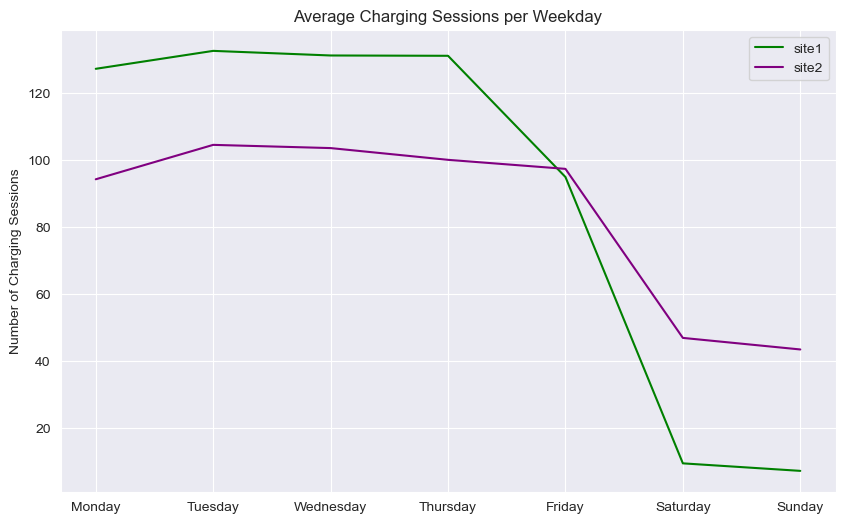

In [6]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
charging_data['day'] = pd.Categorical(charging_data['day'], categories=weekday_order, ordered=True)
charging_data['week'] = charging_data["connectionTime"].dt.isocalendar().week

# calculate number of charging sessions per week and day
sessions_per_week_weekday_site1 = charging_data[charging_data['siteID'] == '1'].groupby(['week', 'day'],
                                                                                        observed=False).size()
sessions_per_week_weekday_site2 = charging_data[charging_data['siteID'] == '2'].groupby(['week', 'day'],
                                                                                        observed=False).size()
# print(sessions_per_day_weekday_site1.head())

# calculate average number of charging sessions per weekday
average_sessions_per_weekday_site1 = sessions_per_week_weekday_site1.groupby('day', observed=False).mean()
average_sessions_per_weekday_site2 = sessions_per_week_weekday_site2.groupby('day', observed=False).mean()

plt.figure(figsize=(10, 6))
average_sessions_per_weekday_site1.plot(kind='line', label='site1', color='green')
average_sessions_per_weekday_site2.plot(kind='line', label='site2', color='purple')
plt.title('Average Charging Sessions per Weekday')
plt.xlabel(None)
plt.ylabel('Number of Charging Sessions')
plt.legend(loc=0)
plt.grid(True)
plt.show()

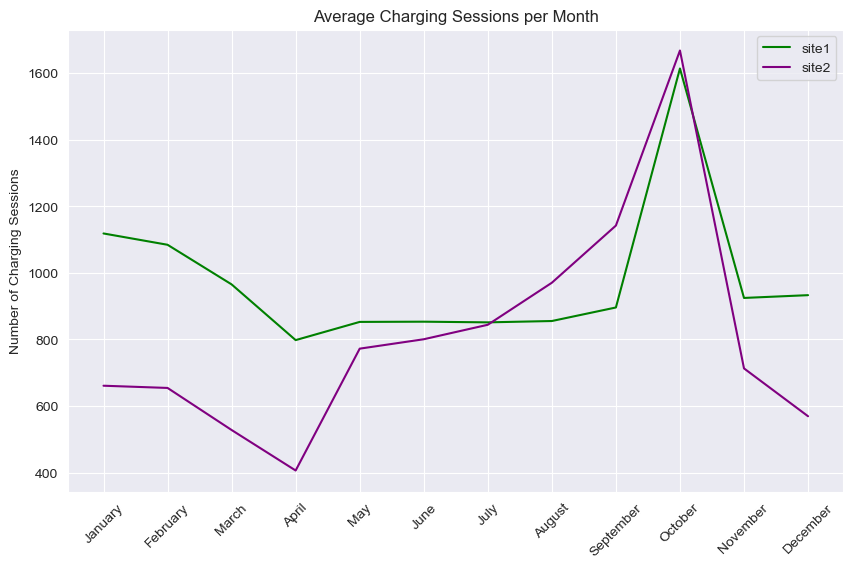

In [7]:
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October',
                'November', 'December']
charging_data['month'] = pd.Categorical(charging_data['connectionTime'].dt.month_name(), categories=months_order,
                                        ordered=True)
charging_data['year'] = charging_data['connectionTime'].dt.year

# calculate number of charging sessions per day and day of the week
sessions_per_year_month_site1 = charging_data[charging_data['siteID'] == '1'].groupby(['year', 'month'],
                                                                                      observed=True).size()
sessions_per_year_month_site2 = charging_data[charging_data['siteID'] == '2'].groupby(['year', 'month'],
                                                                                      observed=True).size()
# print(sessions_per_year_month_site1)

# calculate average number of charging sessions per day of the week
average_sessions_per_month_site1 = sessions_per_year_month_site1.groupby('month', observed=False).mean()
average_sessions_per_month_site2 = sessions_per_year_month_site2.groupby('month', observed=False).mean()

plt.figure(figsize=(10, 6))
average_sessions_per_month_site1.plot(kind='line', label='site1', color='green')
average_sessions_per_month_site2.plot(kind='line', label='site2', color='purple')
plt.title('Average Charging Sessions per Month')
plt.xlabel(None)
plt.ylabel('Number of Charging Sessions')
plt.legend(loc=0)
plt.xticks(range(0, 12), months_order, rotation=45)
plt.grid(True)
plt.show()

## 3 Utilization Prediction
### Data Preparation

In [8]:
def aggregate_charging_data(df, start_date, end_date):
    # Erstellen einer Liste aller Stunden im Datumsbereich
    all_hours = pd.date_range(start=start_date, end=end_date, freq='h')
    # Erstellen eines leeren DataFrames für die aggregierten Daten
    aggregated_df = pd.DataFrame(index=all_hours)
    aggregated_df.index.name = 'start_hour'

    total_hourly_chargingDuration = [0] * len(all_hours)
    total_hourly_connectionDuration = [0] * len(all_hours)
    total_numberOfSpaces = 0
    # Iterieren über die Standorte
    for site_id in df['siteID'].unique():
        site_df = df[df['siteID'] == site_id].copy()
        numberOfSpaces = len(site_df['spaceID'].unique())
        total_numberOfSpaces += numberOfSpaces
        
        hourly_activeSessions = []
        hourly_utilizationRate = []
        hourly_kwhDelivered = []
        hourly_idleRate = []
        hourly_blockedRate = []
        for index, hour in enumerate(all_hours):
            start_of_hour = hour
            end_of_hour = hour + pd.Timedelta(hours=1)
            # Alle chargingSessions, die in der Stunde aktiv waren
            #   folgende Edge-Cases werden aber mitgezählt!:
            #       Wenn eine session genau zum Anfang der Stunde beendet wurde oder
            #       Wenn eine session genau zum Ende der Stunde anfängt
            active_chargers = site_df[(site_df['connectionTime'] <= end_of_hour) & (site_df['disconnectTime'] >= start_of_hour)]
            hourly_activeSessions.append(len(active_chargers))
            
            total_kwh_in_hour = 0
            total_chargingDuration_in_hour = 0
            total_connectionDuration_in_hour = 0
            for _, charger in active_chargers.iterrows():
                # Wir wollen diverse Kennzahlen wie z.B. die kwhDelivered anteilig berechnen:
                #   daher nehmen wir entweder die connectionTime/ doneChargignTime oder start_hour - je nachdem was größer ist
                #   bei der disconnectTime/ doneChargingTime genauso nur umgekehrt
                connectionTime = max(charger['connectionTime'], start_of_hour)
                disconnectTime = min(charger['disconnectTime'], end_of_hour)
                doneChargingTime = min(charger['doneChargingTime'], end_of_hour)
                # Wie lange wurde in der einen Stunde tatsächlich geladen bzw. wie lange war man tatsächlich verbunden?
                chargingDuration_in_hour = (doneChargingTime - connectionTime).total_seconds() / 3600 #Dauer in Stunden
                connectionDuration_in_hour = (disconnectTime - connectionTime).total_seconds() / 3600 #Dauer in Stunden
                total_connectionDuration_in_hour += connectionDuration_in_hour
                
                # Edge Cases:   chargingSessions haben genau zum Ende der Stunde angefangen 
                #               bzw. zum Anfang der Stunde aufgehört
                #               ODER: chargingSessions befinden sich in idleTime
                if chargingDuration_in_hour > 0:
                    kwh_in_hour = (charger['kWhDelivered'] / 
                                   ((charger['doneChargingTime'] - charger['connectionTime']).total_seconds() / 3600)) * chargingDuration_in_hour
                    total_kwh_in_hour += kwh_in_hour
                    total_chargingDuration_in_hour += chargingDuration_in_hour

            # Berechnung der Kennzahlen
            hourly_kwhDelivered.append(total_kwh_in_hour)
            # hourly_utilizationRate.append(total_chargingDuration_in_hour / numberOfSpaces)
            hourly_utilizationRate.append(total_connectionDuration_in_hour / numberOfSpaces)
            total_hourly_chargingDuration[index] += total_chargingDuration_in_hour
            total_hourly_connectionDuration[index] += total_connectionDuration_in_hour
            if total_connectionDuration_in_hour > 0:
                hourly_idleRate.append(total_chargingDuration_in_hour / total_connectionDuration_in_hour)
                hourly_blockedRate.append((total_connectionDuration_in_hour - total_chargingDuration_in_hour) / numberOfSpaces)
            else:
                hourly_idleRate.append(0)
                hourly_blockedRate.append(0)
                

        aggregated_df[f'activeSessions_site{site_id}'] = hourly_activeSessions
        aggregated_df[f'utilizationRate_site{site_id}'] = hourly_utilizationRate
        aggregated_df[f'kWhDelivered_site{site_id}'] = hourly_kwhDelivered
        aggregated_df[f'idleRate_site{site_id}'] = hourly_idleRate
        aggregated_df[f'blockedRate_site{site_id}'] = hourly_blockedRate

    aggregated_df.fillna(0, inplace=True)
    aggregated_df['activeSessions_total'] = aggregated_df['activeSessions_site1'] + aggregated_df['activeSessions_site2']
    aggregated_df['kWhDelivered_total'] = aggregated_df['kWhDelivered_site1'] + aggregated_df['kWhDelivered_site2']
    # aggregated_df['utilizationRate_total'] = np.array(total_hourly_chargingDuration) / total_numberOfSpaces
    aggregated_df['utilizationRate_total'] = np.array(total_hourly_connectionDuration) / total_numberOfSpaces
    aggregated_df['idleRate_total'] = np.divide(
        total_hourly_chargingDuration,
        total_hourly_connectionDuration,
        out=np.zeros_like(total_hourly_chargingDuration, dtype=float), # wichtig für korrekten Datentyp
        where=np.array(total_hourly_connectionDuration) != 0
    )
    aggregated_df['blockedRate_total'] = (np.array(total_hourly_connectionDuration) - np.array(total_hourly_chargingDuration)) / total_numberOfSpaces
    return aggregated_df

In [9]:
# aggregated_data = aggregate_charging_data(charging_data, charging_data['connectionTime'].min().floor('h'),
#                                           charging_data['disconnectTime'].max().ceil('h'))
aggregated_data = aggregate_charging_data(charging_data, pd.to_datetime('2019-12-28').tz_localize('America/Los_Angeles'),
                                          pd.to_datetime('2019-12-29').tz_localize('America/Los_Angeles'))

# Hinzufügen der Zeitspalten
aggregated_data['hour_of_day'] = aggregated_data.index.hour
aggregated_data['week_of_year'] = aggregated_data.index.isocalendar().week
aggregated_data['day_of_week'] = aggregated_data.index.dayofweek  # 0=Montag, 6=Sonntag
aggregated_data['month_of_year'] = aggregated_data.index.month
aggregated_data['is_weekend'] = aggregated_data.index.dayofweek >= 5  # Samstag (5) oder Sonntag (6)
aggregated_data['date'] = aggregated_data.index.date
aggregated_data.head()

,activeSessions_site2,utilizationRate_site2,kWhDelivered_site2,idleRate_site2,blockedRate_site2,activeSessions_site1,utilizationRate_site1,kWhDelivered_site1,idleRate_site1,blockedRate_site1,...,kWhDelivered_total,utilizationRate_total,idleRate_total,blockedRate_total,hour_of_day,week_of_year,day_of_week,month_of_year,is_weekend,date
start_hour,,,,,,,,,,,,,,,,,,,,,
2019-12-28 00:00:00-08:00,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,52,5,12,True,2019-12-28
2019-12-28 01:00:00-08:00,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,52,5,12,True,2019-12-28
2019-12-28 02:00:00-08:00,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2,52,5,12,True,2019-12-28
2019-12-28 03:00:00-08:00,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3,52,5,12,True,2019-12-28
2019-12-28 04:00:00-08:00,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4,52,5,12,True,2019-12-28


In [10]:
# die Wetterdaten werden immer um 7:53h, 8:53h etc. geliefert -> wir runden also auf die nächste Stunde auf
def round_timestamp(timestamp):
    try:
        # Versuchen, den Zeitstempel zu runden
        return timestamp.round('h')
    except:
#       ... das klappt allerdings nicht immer aufgrund der Sommer-Zeitumstellungen
#           -> in dem Fall lassen wir den timestamp einfach so wie er ist
        return timestamp

def merge_with_weather_data(agg_data, weather):
    weather_data = weather.copy()
    aggregated_data = agg_data.copy()
    weather_data['timestamp'] = weather_data['timestamp'].apply(round_timestamp)
    # auf stündliche Daten reduzieren (falls irgendwo mehrere Aufzeichnungen pro Stunde geliefert werden)
    weather_data = weather_data.set_index('timestamp').resample('h').first().reset_index()
    weather_data = weather_data.rename(columns={'timestamp': 'start_hour'})
    
    aggregated_data = pd.merge(aggregated_data, weather_data, on='start_hour', how='left')
    aggregated_data.drop(columns=['city', 'felt_temperature', 'weather_date'], inplace=True)
    return aggregated_data

aggregated_data = merge_with_weather_data(aggregated_data, weather_data)
aggregated_data.columns

Index(['start_hour', 'activeSessions_site2', 'utilizationRate_site2',
       'kWhDelivered_site2', 'idleRate_site2', 'blockedRate_site2',
       'activeSessions_site1', 'utilizationRate_site1', 'kWhDelivered_site1',
       'idleRate_site1', 'blockedRate_site1', 'activeSessions_total',
       'kWhDelivered_total', 'utilizationRate_total', 'idleRate_total',
       'blockedRate_total', 'hour_of_day', 'week_of_year', 'day_of_week',
       'month_of_year', 'is_weekend', 'date', 'temperature', 'cloud_cover',
       'cloud_cover_description', 'pressure', 'windspeed', 'precipitation'],
      dtype='object')

In [11]:
agg_data_import.head()

,activeSessions_site2,utilizationRate_site2,kWhDelivered_site2,idleRate_site2,blockedRate_site2,activeSessions_site1,utilizationRate_site1,kWhDelivered_site1,idleRate_site1,blockedRate_site1,...,pressure,windspeed,precipitation,hour_of_day,week_of_year,day_of_week,month_of_year,is_weekend,date,year
start_hour,,,,,,,,,,,,,,,,,,,,,
2018-04-25 04:00:00-07:00,1,0.016029,3.118359,1.000000,0.000000,0,0.0,0.0,0.0,0.0,...,989.11,11.0,0.0,4,17,2,4,False,2018-04-25,2018
2018-04-25 05:00:00-07:00,1,0.018519,3.602725,1.000000,0.000000,0,0.0,0.0,0.0,0.0,...,989.11,7.0,0.0,5,17,2,4,False,2018-04-25,2018
2018-04-25 06:00:00-07:00,3,0.015175,3.170394,1.000000,0.000000,0,0.0,0.0,0.0,0.0,...,989.44,9.0,0.0,6,17,2,4,False,2018-04-25,2018
2018-04-25 07:00:00-07:00,7,0.059378,12.224048,0.957030,0.002551,0,0.0,0.0,0.0,0.0,...,989.44,7.0,0.0,7,17,2,4,False,2018-04-25,2018
2018-04-25 08:00:00-07:00,22,0.253596,36.984350,0.926976,0.018519,0,0.0,0.0,0.0,0.0,...,990.10,6.0,0.0,8,17,2,4,False,2018-04-25,2018


### Descriptive Analysis

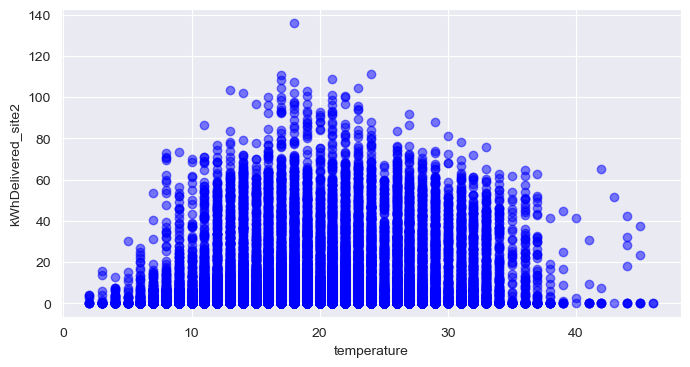

In [12]:
# Just for visual purpose
plt.figure(figsize=(8, 4))
namex = 'temperature'
# namey = 'activeSessions_site2'
namey = 'kWhDelivered_site2'
plt.scatter(agg_data_import[namex], agg_data_import[namey], c='blue', alpha=0.5)
# plt.title("Scatter connection_duration über connectionTime")
plt.xlabel(namex)
plt.ylabel(namey)
plt.grid(True)

## Clustering

In [13]:
charging_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64913 entries, 30793 to 20178
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype                              
---  ------               --------------  -----                              
 0   counter              64913 non-null  int64                              
 1   id                   64913 non-null  object                             
 2   connectionTime       64913 non-null  datetime64[ns, America/Los_Angeles]
 3   disconnectTime       64913 non-null  datetime64[ns, America/Los_Angeles]
 4   doneChargingTime     60831 non-null  datetime64[ns, America/Los_Angeles]
 5   kWhDelivered         64913 non-null  float64                            
 6   sessionID            64913 non-null  object                             
 7   siteID               64913 non-null  object                             
 8   spaceID              64913 non-null  object                             
 9   stationID            64913 no

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Auswahl der für das Clustering relevanten Spalten
charging_data['day_of_week'] = charging_data['connectionTime'].dt.dayofweek

# sessions_clustering = charging_data[charging_data['siteID'] == '2']
# charging_data_clustering = charging_data[['kWhDelivered', 'charging_duration', 'connection_duration', 'hour', 'day_of_week']]
sessions_clustering = charging_data[['kWhDelivered', 'charging_duration', 'connection_duration', 'hour']]

# Initialisierung und Anpassen des Standard Scalers
scaler = StandardScaler()
scaler.fit(sessions_clustering)

# Skalierung der Daten
sessions_clustering_scaled = scaler.transform(sessions_clustering)
sessions_clustering_scaled = pd.DataFrame(sessions_clustering_scaled, columns=sessions_clustering.columns)

# K-Means Clustering
kmeans_1 = KMeans(n_clusters=3, random_state=100, init='k-means++')
sessions_clustering_scaled['kmeans_cluster'] = kmeans_1.fit_predict(sessions_clustering_scaled)

# Reverse Transform (Zurücksetzen der Skalierung)
sessions_clustering_unscaled = scaler.inverse_transform(sessions_clustering_scaled.drop('kmeans_cluster', axis=1))
sessions_clustering_unscaled = pd.DataFrame(sessions_clustering_unscaled, columns=sessions_clustering.columns)

sessions_clustering_unscaled['kmeans_cluster'] = sessions_clustering_scaled['kmeans_cluster']

# Erstellung des Pairplots mit den unskalierten Daten
sns.pairplot(data=sessions_clustering_unscaled, hue="kmeans_cluster", palette="tab10")

plt.show()

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## Training Models

In [14]:
from sklearn.model_selection import train_test_split

# Cross Validation
# train_X, test_X, train_y, test_y = train_test_split(
#     agg_data_import[['hour_of_day', 'day_of_week', 'week_of_year']],
#     agg_data_import[['activeSessions_site1']], test_size=0.3)
train_X, test_X, train_y, test_y = train_test_split(
    agg_data_import[['hour_of_day', 'week_of_year', 'day_of_week',
       'month_of_year', 'is_weekend']],
    agg_data_import[['activeSessions_site1']], test_size=0.3)

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
scaler.fit(train_X)  # Fit the scaler on the training data
train_X_scaled = scaler.transform(train_X)
test_X_scaled = scaler.transform(test_X)

# Transform features
poly = PolynomialFeatures(degree=5, include_bias=False)
X_poly_scaled = poly.fit_transform(train_X_scaled)
X_test_poly_scaled = poly.transform(test_X_scaled)

# Regularization
model_L1 = Lasso(alpha = 0.01, max_iter=10_000)
# model_L1 = Lasso(alpha = 0, max_iter=10_000)

model_L1.fit(X_poly_scaled, train_y)
# Make predictions
y_pred = model_L1.predict(X_test_poly_scaled)

# Evaluation
mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, y_pred)

print(mse, rmse, r2)

136.28958610471935 11.674313089202265 0.4911399297651644


/opt/anaconda3/envs/DynamoData/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.353e+03, tolerance: 5.569e+02
  model = cd_fast.enet_coordinate_descent(


In [16]:
import numpy as np

# feature = 'hour_of_day'
#
# plt.scatter(train_X, train_y, color='blue', label='Train Data')
# plt.scatter(test_X, test_y, color='red', label='Test Data')
#
# # Sortiere die x-Werte des Testdatensatzes
# x_sorted = np.sort(test_X)
#
# # Erzeuge die entsprechenden sortierten Vorhersagen
# X_test_sorted = np.array(x_sorted).reshape(-1, 1) #Reshape für scikit-learn
# X_test_poly_sorted = poly.transform(X_test_sorted)
# y_pred_sorted = model.predict(X_test_poly_sorted)
#
# # Plotten der Regressionslinie mit sortierten Werten
# plt.plot(x_sorted, y_pred_sorted, color='green', label='Prediction')
#
# plt.xlabel(feature)
# plt.ylabel('activeSessions_site1')
# plt.legend()
# plt.title(f'Linear Regression with Polynomial Features for {feature}')
# plt.show()

In [17]:
len(train_X)

20801

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
import graphviz

# Cross Validation
train_X, test_X, train_y, test_y = train_test_split(
    agg_data_import[['year', 'hour_of_day', 'week_of_year', 'day_of_week',
       'month_of_year', 'temperature', 'cloud_cover', 'pressure', 'windspeed', 'precipitation']],
    agg_data_import[['activeSessions_site1']], test_size=0.3)
       # 'month_of_year', 'is_weekend', 'temperature', 'cloud_cover', 'pressure', 'windspeed', 'precipitation']],
# train_X, test_X, train_y, test_y = train_test_split(
#     agg_data_import[['year', 'hour_of_day', 'week_of_year', 'day_of_week',
#        'month_of_year', 'is_weekend']],
#     agg_data_import[['activeSessions_site1']], test_size=0.3)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': range(1, 7),  # Test depths from 1 to 10
    'min_samples_split': range(200, 500),  # Minimum samples to split a node
    'min_samples_leaf': range(50, 200) # Minimum samples to be a leaf
}

# Create the DecisionTreeRegressor model
model_tree = DecisionTreeRegressor(max_depth=7)  # Adjust max_depth for complexity

# Train the model
model_tree.fit(train_X, train_y)

# Make predictions
y_pred = model_tree.predict(test_X)

# # Perform GridSearchCV
# grid_search = GridSearchCV(model_tree, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=False, n_jobs=-1) #added n_jobs=-1 for parallel processing
# grid_search.fit(train_X, train_y)
# # Get the best model
# best_tree = grid_search.best_estimator_

# Make predictions
# y_pred = best_tree.predict(test_X)
y_pred = model_tree.predict(test_X)

# Evaluation
mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, y_pred)


# Visualize the decision tree
dot_data = export_graphviz(model_tree, out_file=None,
                           filled=True, rounded=True,
                           special_characters=True,
                           feature_names = train_X.columns)
graph = graphviz.Source(dot_data)
graph.render(filename="decision_tree", directory=os.getcwd(), format='pdf', cleanup=True)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R^2: {r2:.4f}")
# graph

Mean Squared Error (MSE): 49.4670
Root Mean Squared Error (RMSE): 7.0333
R^2: 0.8139


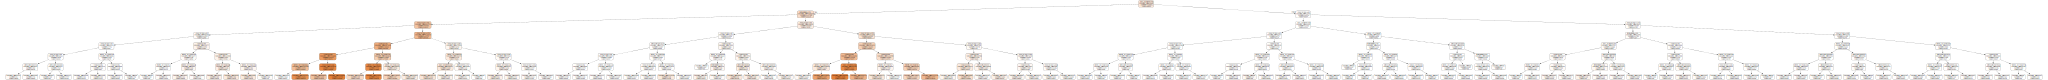

In [19]:
graph
